In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
import numbers

# Exploratory Data Analysis

In [53]:
df = pd.read_csv("data/Students_Performance_mv.csv")
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [54]:
# Drop numerical columns
df.drop(columns=['math score','reading score','writing score'], inplace=True)

In [55]:
# Find the number of missing values per column.
df.isnull().sum()

gender                          0
race/ethnicity                 11
parental level of education    21
lunch                          12
test preparation course         4
dtype: int64

In [56]:
df.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course'],
      dtype='object')

# Starting the Algorithm

In [57]:
def ExtractCompleteTuples(df):
    # getting the rows without null values
    CT = df.dropna()
    return CT   # CT.shape #(959, 5)

In [58]:
def ExtractInCompleteTuples(df):
    # getting only the rows with null values
    ICT = df[df.isnull().any(axis=1)]
    # print(ICT.shape) #(41, 5)
    return ICT.values

In [59]:
from math import log,e

# Entropy weight method (EWM)
def ComputeAttributeWeights(CT):
    n = CT.shape[0] # the number of rows in complete tuples
    s = CT.shape[1] # the number of columns

    # 1- Normalizing data(just numerocal cols)

    # 2-1 Calculating the entropy of each numerical attribute   
    
    # 2-2 Calculating the entropy of each categorical attribute 
    def entropy(labels, base=None):
        vc = pd.Series(labels).value_counts(normalize=True, sort=False)
        base = e if base is None else base
        return -(vc * np.log(vc)/np.log(base)).sum()

    E = []          # [0.6924027159890356, 1.5185039737243646, 1.71940544072419, 0.6502094546756849, 0.6508318554230292]
    for column in CT:
        E.append(entropy(CT[column], base=None))
    # 3- Determining the weight of each attribute
    w = [0] * s     # [-1.3295556932195063, 2.241176844063399, 3.1095515115596424, -1.5119314608568568, -1.5092412015466796]
    # TODO what is k?
    k = s
    sum = 0
    for i in range(k):
        sum += E[i]

    for i in range(s):
        w[i] = (1 - E[i]) / (k - sum)

    return w

In [60]:
def SortInCompleteTuples(ICT, r):
    # Convert list to npArray
    r = np.array(r)

    # Arg sort
    argSort = np.argsort(r) # it sorts r, and returns corresponding indexes
    
    # Create new empty npArray for sorted ICT
    sortedICT = np.copy(ICT)
    for index in range(argSort.size):
        sortedICT[index] = ICT[argSort[index]]
    
    return sortedICT

In [61]:
def Partition(seq, num):
    avg  = len(seq) / float(num)
    out  = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

In [62]:
def GenerateTuplePartition(sortedICT, m):
    T = []
    T = Partition(sortedICT, m)
    return T

In [63]:
def GenerateTuplePartitions(ICT, CT, m, s):

    W = ComputeAttributeWeights(CT)
    # STEP 1
    # Calculate tuple integrity rate, according to DEFINITION 5(example)
    inCompleteRowsCount = ICT.shape[0]      # the number of ICT rows
    r = [1] * inCompleteRowsCount                      
    for i in range(inCompleteRowsCount):
        for j in range(s):
            if pd.isnull(ICT[i][j]):
                r[i] = r[i] - W[j]    
    # TODO  r (-4.350728355623041, 2.511931460856857) ?      

    # STEP 2
    # sort ICT's tuples according to their integrity rate
    sortedICT = SortInCompleteTuples(ICT, r)
    
    # STEP 3
    tuplePartitions = GenerateTuplePartition(sortedICT, m)
    return tuplePartitions # a queue of subsets

In [64]:
# Defining a function which calculates euclidean distance between two data points(numerical)
def euclideanDistance(data1, data2, length):
    distance = 0
    for x in range(length):
        distance += np.square(data1[x] - data2[x])
    return np.sqrt(distance)

In [65]:
def distance_matrix(complete_set,incomplete_set, numeric_distance = "euclidean", categorical_distance = "hamming"):
    
    # Get the type of each attribute (Numeric or categorical)
    is_numeric = [all(isinstance(n, numbers.Number) for n in complete_set.iloc[:, i]) for i, x in enumerate(complete_set)]
    is_all_categorical = sum(is_numeric) == 0

    if categorical_distance == 'hamming':
        complete_set = pd.DataFrame([pd.factorize(complete_set[x])[0] for x in complete_set]).transpose()
        incomplete_set = pd.DataFrame([pd.factorize(incomplete_set[x])[0] for x in incomplete_set]).transpose()

    if is_all_categorical:
        if categorical_distance == "hamming":
            result_matrix = cdist(complete_set, incomplete_set, metric=categorical_distance)

    return pd.DataFrame(result_matrix)

In [66]:
def knn_impute(complete_set, incomplete_set, k_neighbors, aggregation_method="mode", numeric_distance="euclidean",
               categorical_distance="hamming"):
    
    numberOfICSamples=len(incomplete_set)
    target=[]
    
    # Make sure the data are in the right format
    incomplete_set = pd.DataFrame(incomplete_set)
    complete_set = pd.DataFrame(complete_set)
    
    # Get the distance matrix and check whether no error was triggered when computing it
    distances = distance_matrix(complete_set,incomplete_set, numeric_distance, categorical_distance)

    # Get the closest points and compute the correct aggregation method
    for j in range(numberOfICSamples):
        for i, value in enumerate(incomplete_set.iloc[j, :]):
            if pd.isnull(value):
                order = distances.iloc[:,i].values.argsort()[:k_neighbors]
                closest_to_target = complete_set.iloc[order, i]
                incomplete_set.iloc[j,i]=stats.mode(closest_to_target)[0][0]
    
    target=incomplete_set
    return target

In [67]:
def KNNImputation(train_set, test_set):
    return knn_impute(train_set, test_set, k_neighbors=5)

In [68]:
def Merge(a, b):
    a=np.array(a)
    b=np.array(b)
    return np.concatenate((a, b), axis=0)

In [69]:
# Begin
CT  = ExtractCompleteTuples(df)   # this is dataframe
ICT = ExtractInCompleteTuples(df) # this is npArray


# The number of partitions
m = 5 # TODO ?
# The number of attributes
s = df.columns.size    # 5

T = GenerateTuplePartitions(ICT, CT, m, s)

CTS    = [[0]] * (m+1)
Tp     = [[0]] * (m)
CTS[0] = np.array(CT.copy())

for i in range(1, m+1):
    Tp[i-1] = KNNImputation(CTS[i-1], T[i-1])
    CTS[i]  = Merge(CTS[i-1], Tp[i-1])


print(CTS[m])  #1000 


# Do cross validation
# for i in range(1, m-1):


[['female' 'group B' "bachelor's degree" 'standard' 'none']
 ['female' 'group C' 'some college' 'standard' 'completed']
 ['female' 'group B' "master's degree" 'standard' 'none']
 ...
 ['female' 'group E' "associate's degree" 'free/reduced' 'none']
 ['female' 'group B' "bachelor's degree" 'free/reduced' 'none']
 ['female' 'group E' 'some college' 'free/reduced' 'completed']]


## Calculate Evaluation metrics 

In [70]:
# convert CTS[m] to a dataFrame
df = pd.DataFrame(CTS[m], columns=['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course'])
# df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
dtypes: object(5)
memory usage: 39.2+ KB


In [71]:
# Find the number of missing values per column.
df.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
dtype: int64

In [72]:
df['gender']                      = df['gender'].map({'male':0, 'female':1})
df['race/ethnicity']              = df['race/ethnicity'].map({'group A':0, 'group B':1, 'group C':2, 'group D':3, 'group E':4})
df['parental level of education'] = df['parental level of education'].map({"bachelor's degree":0, "high school":1, "some college":2, "master's degree":3, "associate's degree":4, "some high school":5})
df['lunch']                       = df['lunch'].map({'standard':0, 'free/reduced':1})
df['test preparation course']     = df['test preparation course'].map({'none':0, 'completed':1})

df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course
0,1,1,0,0,0
1,1,2,2,0,1
2,1,1,3,0,0
3,0,0,4,1,0
4,0,2,2,0,0


In [73]:
target = np.array(df['gender'])
data   = np.array(df.loc[:, df.columns != 'gender'])

In [74]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(data, target, random_state=42)


print("shape of train data:   ", xTrain.shape)
print("shape of test  data:   ", xTest.shape)
print("shape of train target: ", yTest.shape)
print("shape of test  target: ", yTrain.shape)

shape of train data:    (750, 4)
shape of test  data:    (250, 4)
shape of train target:  (250,)
shape of test  target:  (750,)


/home/paghsa/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gender', ylabel='count'>

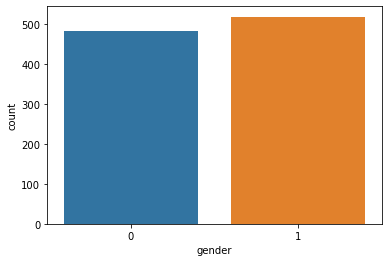

In [75]:
import seaborn as sns
sns.countplot(df['gender'])

In [76]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(xTrain, yTrain)

yPred = knn.predict(xTest)
print(knn.score(xTrain, yTrain))
print(knn.score(xTest,  yTest))

0.6106666666666667
0.496


In [77]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(classification_report(yTest, yPred))

              precision    recall  f1-score   support

           0       0.49      0.54      0.51       122
           1       0.51      0.45      0.48       128

    accuracy                           0.50       250
   macro avg       0.50      0.50      0.50       250
weighted avg       0.50      0.50      0.50       250



<AxesSubplot:>

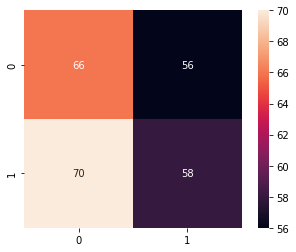

In [78]:
cm = confusion_matrix(yTest, yPred)
sns.heatmap(cm, square=True, annot=True)